In [1]:
!pip uninstall -y gcsfs bigframes -q

In [14]:
!pip install -U fsspec==2024.12.0 datasets scikit-learn huggingface_hub tldextract pandas==2.2.2 numpy joblib tqdm scipy

In [27]:
import math
import numpy as np
import pandas as pd
import tldextract
import joblib
from datasets import load_dataset
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    roc_curve,
    precision_recall_curve,
)
from scipy.sparse import hstack
from tqdm.auto import tqdm

def normalize_label(ex):
    t = (ex.get("Type") or ex.get("label") or "").lower()
    ex["label"] = 1 if "dga" in t else 0
    return ex

def extract_base(domains):
    out = []
    for d in domains:
        ext = tldextract.extract(d.lower())
        out.append(f"{ext.domain}{ext.suffix}")
    return out

def compute_stats(domains):
    feats = []
    for d in domains:
        s = d.lower()
        L = len(s)
        digit_ratio = sum(c.isdigit() for c in s) / max(L,1)
        ps = [s.count(c)/L for c in set(s)]
        entropy = -sum(p * np.log2(p) for p in ps)
        feats.append([L, digit_ratio, entropy])
    return np.array(feats)

def batched(iterable, batch_size):
    it = iter(iterable)
    from itertools import islice
    while True:
        batch = list(islice(it, batch_size))
        if not batch:
            break
        yield batch

In [4]:
from huggingface_hub import login
login()

In [28]:
train_limit = None
test_limit  = None

In [29]:
raw_tune = load_dataset("asobirov/dga-preprocessed", split="train")
raw_tune = raw_tune.map(normalize_label).shuffle(seed=42).select(range(100_000))
df_tune = pd.DataFrame({"domain": raw_tune["domain"], "label": raw_tune["label"]})
X_tune_base  = extract_base(df_tune["domain"])
X_tune_stats = compute_stats(X_tune_base)
y_tune       = df_tune["label"]
del raw_tune, df_tune

# Full test set (or limited)
raw_test = load_dataset("asobirov/dga-preprocessed", split="test")
raw_test = raw_test.map(normalize_label)
if test_limit is not None:
    raw_test = raw_test.shuffle(seed=42).select(range(test_limit))
df_test = pd.DataFrame({"domain": raw_test["domain"], "label": raw_test["label"]})
del raw_test

Map:   0%|          | 0/4894505 [00:00<?, ? examples/s]

Map:   0%|          | 0/900539 [00:00<?, ? examples/s]

In [30]:
stream_train = (
    load_dataset("asobirov/dga-preprocessed", split="train", streaming=True)
      .map(normalize_label)
      .shuffle(buffer_size=100_000)
)
if train_limit is not None:
    stream_train = stream_train.take(train_limit)

In [31]:
ngram_range   = (2,5)
n_features    = 2**20
alpha_list    = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_alpha    = alpha_list[0]
best_score    = -np.inf
tune_every    = 10  # re‑tune every N batches

# estimate class weights on the tune set
counts = pd.Series(y_tune).value_counts().to_dict()
total  = sum(counts.values())
class_weights = {cls: total/(2*cnt) for cls, cnt in counts.items()}

vectorizer = HashingVectorizer(
    analyzer="char",
    ngram_range=ngram_range,
    n_features=n_features,
    alternate_sign=False,
)
X_tune_text = vectorizer.transform(X_tune_base)
X_tune_all  = hstack([X_tune_text, X_tune_stats])

clf = SGDClassifier(
    loss="log_loss",
    alpha=best_alpha,
    class_weight=class_weights,
    random_state=42,
)

In [32]:
first_batch = next(batched(stream_train, 50_000))
dom0        = extract_base([ex["domain"] for ex in first_batch])
X0_text     = vectorizer.transform(dom0)
X0_stats    = compute_stats(dom0)
X0          = hstack([X0_text, X0_stats])
y0          = [ex["label"] for ex in first_batch]
clf.partial_fit(X0, y0, classes=[0,1])

SGDClassifier(alpha=0.001,
              class_weight={0: 1.0303542357862634, 1: 0.9713830551939852},
              loss='log_loss', random_state=42)

In [34]:
# Cell 8: Streaming training + incremental hyperparameter tuning
import copy

batch_size    = 50_000
expected_rows = train_limit or 5_000_000
n_batches     = int(math.ceil(expected_rows / batch_size))

for i, batch in enumerate(tqdm(
    batched(stream_train, batch_size),
    total=n_batches,
    desc="Streaming training"
)):
    doms     = extract_base([ex["domain"] for ex in batch])
    Xt_text  = vectorizer.transform(doms)
    Xt_stats = compute_stats(doms)
    Xb       = hstack([Xt_text, Xt_stats])
    yb       = [ex["label"] for ex in batch]

    # update live model
    clf.partial_fit(Xb, yb)

    # every N batches, try different alphas on a deep‐copy
    if (i + 1) % tune_every == 0:
        for α in alpha_list:
            tmp = copy.deepcopy(clf)             # keep current weights & classes_
            tmp.alpha = α                        # swap in new learning rate
            tmp.partial_fit(Xb, yb)             # one more update with latest batch
            prob = tmp.predict_proba(X_tune_all)[:,1]
            auc  = roc_auc_score(y_tune, prob)
            if auc > best_score:
                best_score = auc
                best_alpha = α

        if best_alpha != clf.alpha:
            print(f"[Batch {i+1}] switching alpha → {best_alpha:.1e} (tune AUC={best_score:.4f})")
            clf.alpha = best_alpha               # update live model’s α

Streaming training:   0%|          | 0/100 [00:00<?, ?it/s]

[Batch 10] switching alpha → 1.0e-05 (tune AUC=0.9361)
[Batch 20] switching alpha → 1.0e-04 (tune AUC=0.9884)
[Batch 40] switching alpha → 5.0e-05 (tune AUC=0.9902)
[Batch 50] switching alpha → 5.0e-04 (tune AUC=0.9912)
[Batch 70] switching alpha → 1.0e-04 (tune AUC=0.9913)
[Batch 80] switching alpha → 5.0e-05 (tune AUC=0.9915)


Accuracy: 0.8570111899651209
              precision    recall  f1-score   support

           0     0.6640    0.9175    0.7704    235474
           1     0.9662    0.8356    0.8962    665065

    accuracy                         0.8570    900539
   macro avg     0.8151    0.8765    0.8333    900539
weighted avg     0.8872    0.8570    0.8633    900539

ROC AUC: 0.9446684694074697


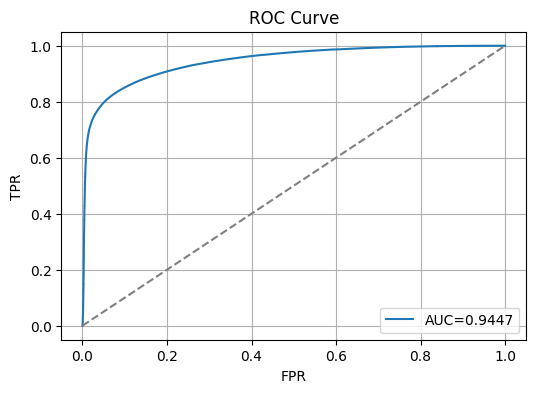

In [39]:
# Cell 9: Evaluate on test set
dom_test    = extract_base(df_test["domain"])
X_test_text = vectorizer.transform(dom_test)
X_test_stats= compute_stats(dom_test)
X_test_all  = hstack([X_test_text, X_test_stats])
y_test      = df_test["label"]

y_prob = clf.predict_proba(X_test_all)[:,1]
opt_thr = 0.2124 # Youden’s J‑optimal

y_pred = (y_prob >= opt_thr).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


fpr, tpr, _ = roc_curve(y_test, y_prob)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test,y_prob):.4f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(); plt.grid(True); plt.show()

In [37]:
from sklearn.metrics import precision_recall_curve
import numpy as np

prec, rec, thr = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)

best_idx = np.argmax(f1_scores[:-1])
opt_thr_f1 = thr[best_idx]
print(f"Best F1 ={f1_scores[best_idx]:.4f} at threshold={opt_thr_f1:.4f}")

Best F1 =0.9200 at threshold=0.0794


In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thr_roc = roc_curve(y_test, y_prob)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
opt_thr_j = thr_roc[best_idx]
print(f"Best Youden’s J ={j_scores[best_idx]:.4f} at threshold={opt_thr_j:.4f}")

Best Youden’s J =0.7531 at threshold=0.2124


In [44]:
# Cell 10: Save model & inference helper
joblib.dump(clf, "dga_detector_full.joblib")

def score_domain(domain: str) -> float:
    base   = extract_base([domain])
    Xt     = vectorizer.transform(base)
    Xs     = compute_stats(base)
    X_all  = hstack([Xt, Xs])
    return float(clf.predict_proba(X_all)[0,1])

# Example
print("example.com →", score_domain("example.com"))

example.com → 0.00727637340350605


In [46]:
from huggingface_hub import login, HfApi, Repository
import shutil

api = HfApi()
repo_id = "asobirov/dga-detector"
api.create_repo(repo_id=repo_id, exist_ok=True)

api.upload_file(
    path_or_fileobj="dga_detector_full.joblib",
    path_in_repo="dga_detector_full.joblib",
    repo_id=repo_id,
    repo_type="model",
    token=True
)

readme_text = """---
license: apache-2.0
datasets:
- asobirov/dga-preprocessed
- harpomaxx/dga-detection
- YangYang-Research/dga-detection
metrics:
- accuracy
- f1
tags:
- dga-detection
- streaming
---

# DGA SGD Detector

This model was trained on the `asobirov/dga-preprocessed` dataset using:
- **HashingVectorizer** (char 2–5 grams, 2**20 hash buckets)
- **SGDClassifier** with online `partial_fit` and incremental learning-rate tuning
- Lightweight stats: length, digit ratio, Shannon entropy
- **Streaming training** on ~5 M domains, evaluated on ~1 M test domains from [harpomaxx/dga-detection](https://huggingface.co/harpomaxx/dga-detection) and [YangYang-Research/dga-detection](https://huggingface.co/YangYang-Research/dga-detection)
- **Decision threshold** optimized for F1 (=0.0794) yielding 85.7% accuracy, 83.6% DGA recall
"""
with open("README.md", "w") as f:
    f.write(readme_text)

api.upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_id,
    repo_type="model",
    token=True
)

print(f"✅ Model and README uploaded to https://huggingface.co/{repo_id}")

No files have been modified since last commit. Skipping to prevent empty commit.


✅ Model and README uploaded to https://huggingface.co/asobirov/dga-detector
